In [30]:
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import cv2
from skimage.io import imread, imsave
from skimage.transform import rescale, resize, downscale_local_mean
%matplotlib inline

In [31]:
def decode(rle_mask):
    mask = rle_mask.split()
    img = np.zeros(256*256, dtype=np.uint8)
    for i, m, in enumerate(mask):
        img[i] = int(m)
    return img.reshape(256,256)


def encode(im):
    pixels = im.flatten()
    return ' '.join(str(x) for x in pixels)

In [32]:
df = pd.read_csv('/opt/ml/segmentation/semantic-segmentation-level2-cv-16/dev/model_develop/mmsegmentation/work_dirs/10-2/10-2_TTA_28000it.csv')

In [33]:
df

,image_id,PredictionString
0,batch_01_vt/0021.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,batch_01_vt/0028.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,batch_01_vt/0031.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,batch_01_vt/0032.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,batch_01_vt/0076.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...
814,batch_03/0947.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
815,batch_03/0968.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
816,batch_03/0969.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
817,batch_03/0992.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


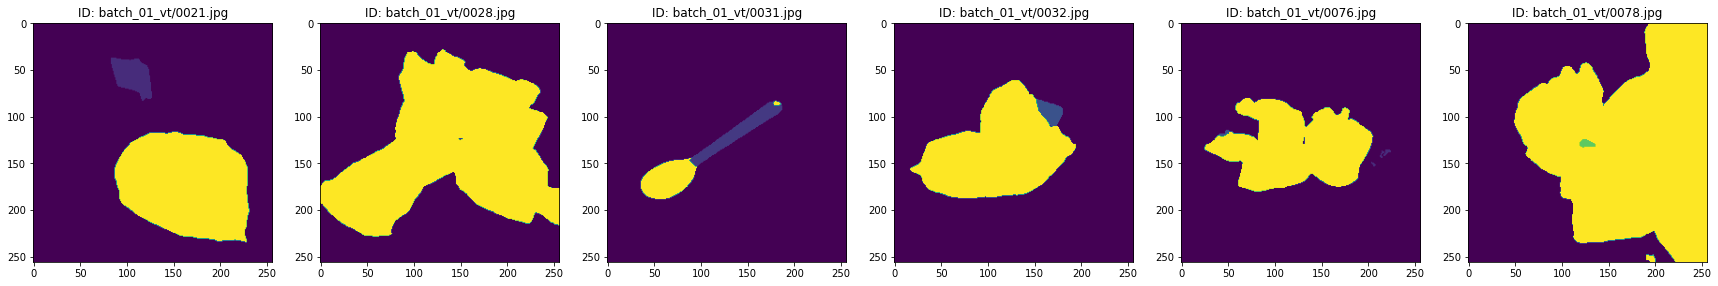

In [34]:
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'image_id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [71]:
def crf(original_image, mask_img):
    
    labels = mask_img.flatten()

    # print(len(labels))
    n_labels = 11
    
    #Setting up the CRF model
    
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3,3), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(3,3), srgb=(70,70,70), rgbim=original_image, compat=7)

    Q = d.inference(50)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [72]:
test_path = '/opt/ml/segmentation/input/data/'

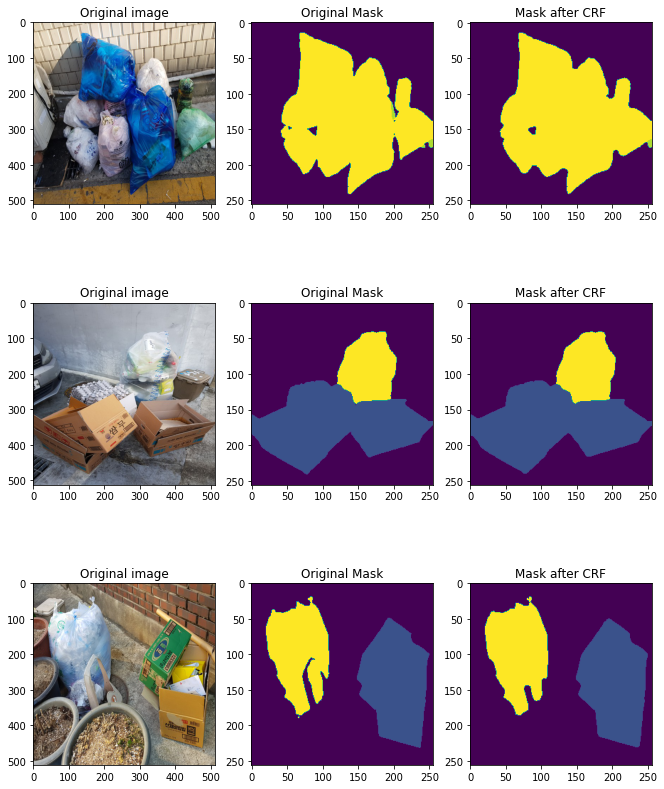

In [74]:
from skimage.util import img_as_ubyte
nImgs = 3
i = np.random.randint(1000)
j = 1
plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..
while True:
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])        
        orig_img = imread(test_path+df.loc[i,'image_id'])
        image_resized = resize(orig_img, (orig_img.shape[0] // 2, orig_img.shape[1] // 2), anti_aliasing=True)
        # print(img_as_ubyte(image_resized))
        crf_output = crf(img_as_ubyte(image_resized),decoded_mask)
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(decoded_mask) 
        plt.title('Original Mask')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(crf_output) 
        plt.title('Mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1

In [ ]:
for i in tqdm(range(df.shape[0])):
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')        
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'PredictionString'] = encode(crf_output)
df.to_csv('crf_correction.csv',index=False)